# Import nessesory libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Initial Exploration

In [8]:
# 1. Data Loading and Initial Exploration
def load_and_explore_data(url, cols):
    """Load and perform initial data exploration"""
    print("Loading dataset...")
    df = pd.read_csv(url, sep=';', low_memory=False, parse_dates={'datetime': ['Date', 'Time']}, 
                infer_datetime_format=True, na_values=['?'], usecols=cols)
    
    # Convert datetime to proper format
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Set datetime as index
    df.set_index('datetime', inplace=True)
    
    # Basic exploration
    print("\nDataset Shape:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData types:")
    print(df.dtypes)
    print("\nBasic statistics:")
    print(df.describe())
    print("\nMissing values:")
    print(df.isnull().sum())
    return df
    
    
# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
cols = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 
        'Voltage', 'Global_intensity', 'Sub_metering_1', 
        'Sub_metering_2', 'Sub_metering_3']
df=load_and_explore_data(url, cols)

Loading dataset...

Dataset Shape: (2075259, 7)

First 5 rows:
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0  

## Data Preprocessing

In [12]:
def preprocess_data(df):
    print("\nPreprocessing data...")
    
    # Handle missing values (if any)
    # For time series, interpolation is often better than dropping

    df_clean= df.interpolate(method='time') # Interpolate missing values

    # Remove any remaining NaN values at the beginning/end
    df_clean = df_clean.dropna()
    
    # Check for outliers using IQR method
    Q1 = df_clean.quantile(0.25)
    Q3 = df_clean.quantile(0.75)
    IQR = Q3 - Q1
    
    # Identify outliers
    outliers = ((df_clean < (Q1 - 1.0 * IQR)) | (df_clean > (Q3 + 1.0 * IQR))).sum()
    print("\nNumber of outliers per column:")
    print(outliers)
    
    # For now, we'll keep outliers but flag them for further investigation
    # Advanced techniques like winsorization could be applied if needed
    
    # Feature engineering - add time-based features
    df_clean['hour'] = df_clean.index.hour
    df_clean['day'] = df_clean.index.day
    df_clean['month'] = df_clean.index.month
    df_clean['year'] = df_clean.index.year
    df_clean['dayofweek'] = df_clean.index.dayofweek  # 0=Monday, 6=Sunday
    df_clean['weekend'] = df_clean['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # For sub-daily data, create a cyclic time feature
    df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour']/24)
    df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour']/24)
    
    return df_clean

df_clean = preprocess_data(df)


Preprocessing data...

Number of outliers per column:
Global_active_power      157142
Global_reactive_power     99575
Voltage                  164480
Global_intensity         159894
Sub_metering_1           172247
Sub_metering_2            77166
Sub_metering_3                0
dtype: int64


## Exploratory Data Analysis


Performing exploratory data analysis...


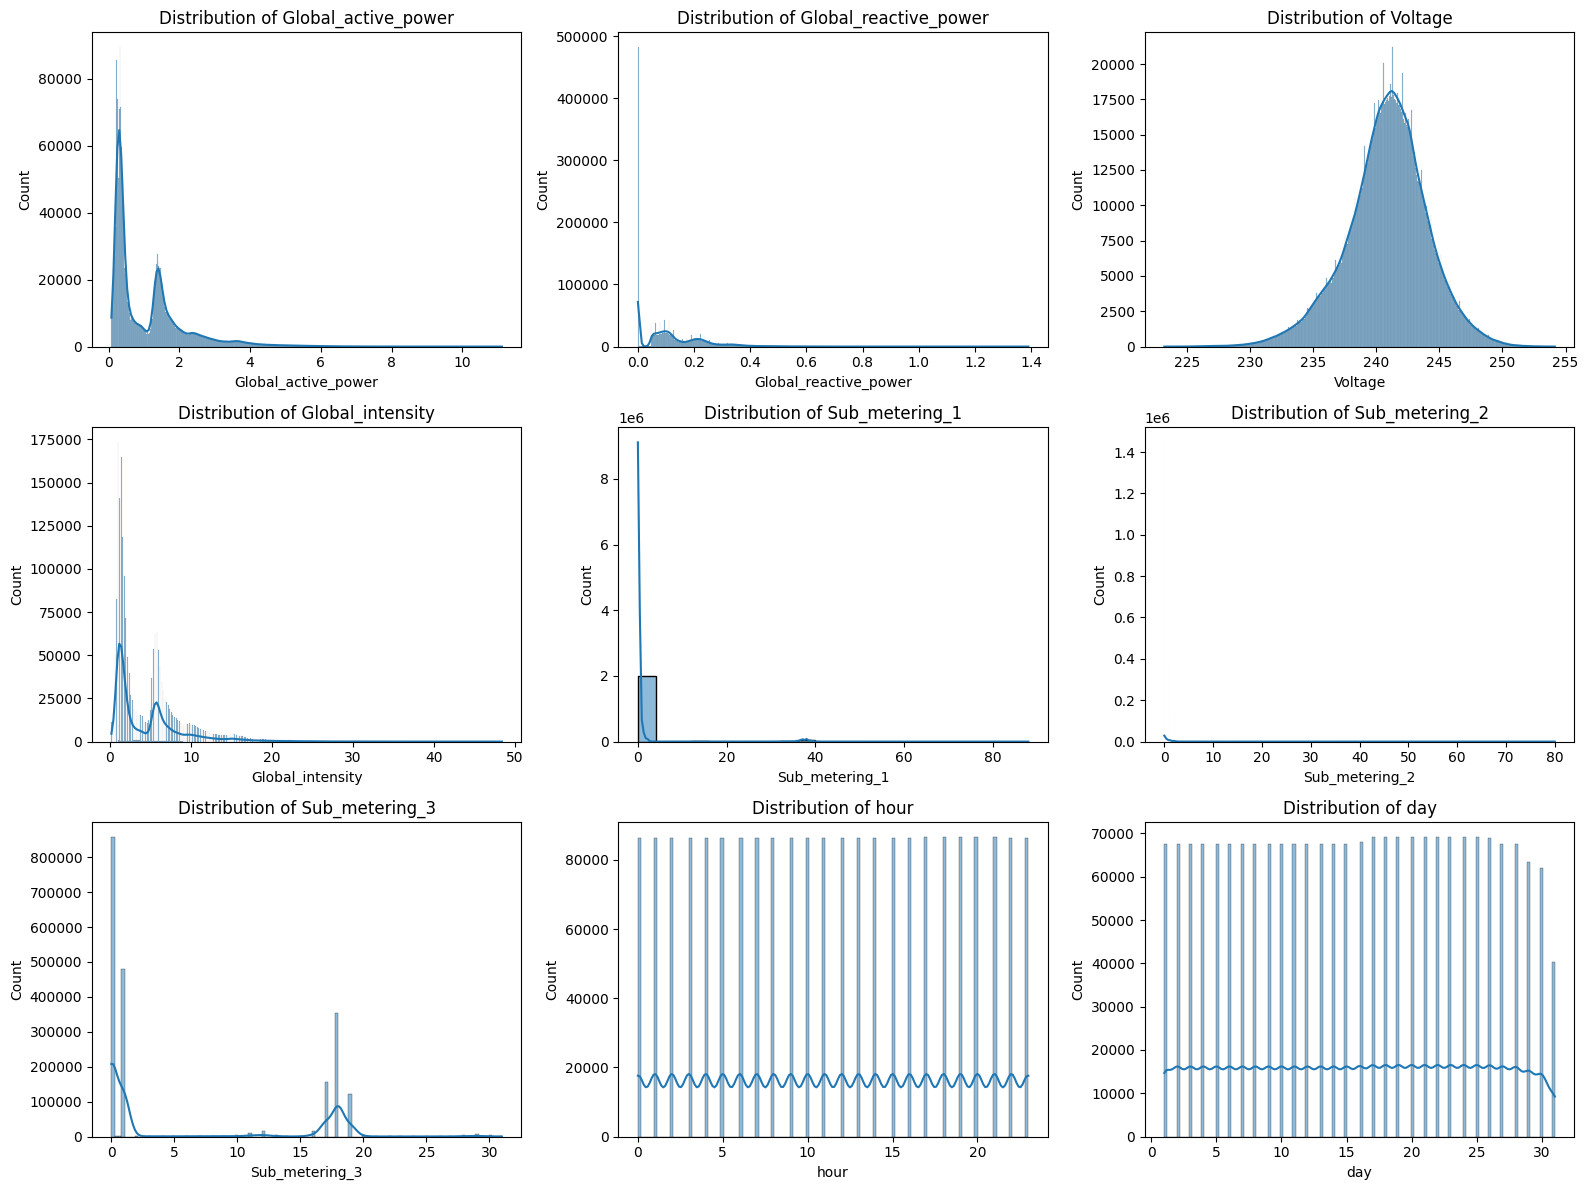

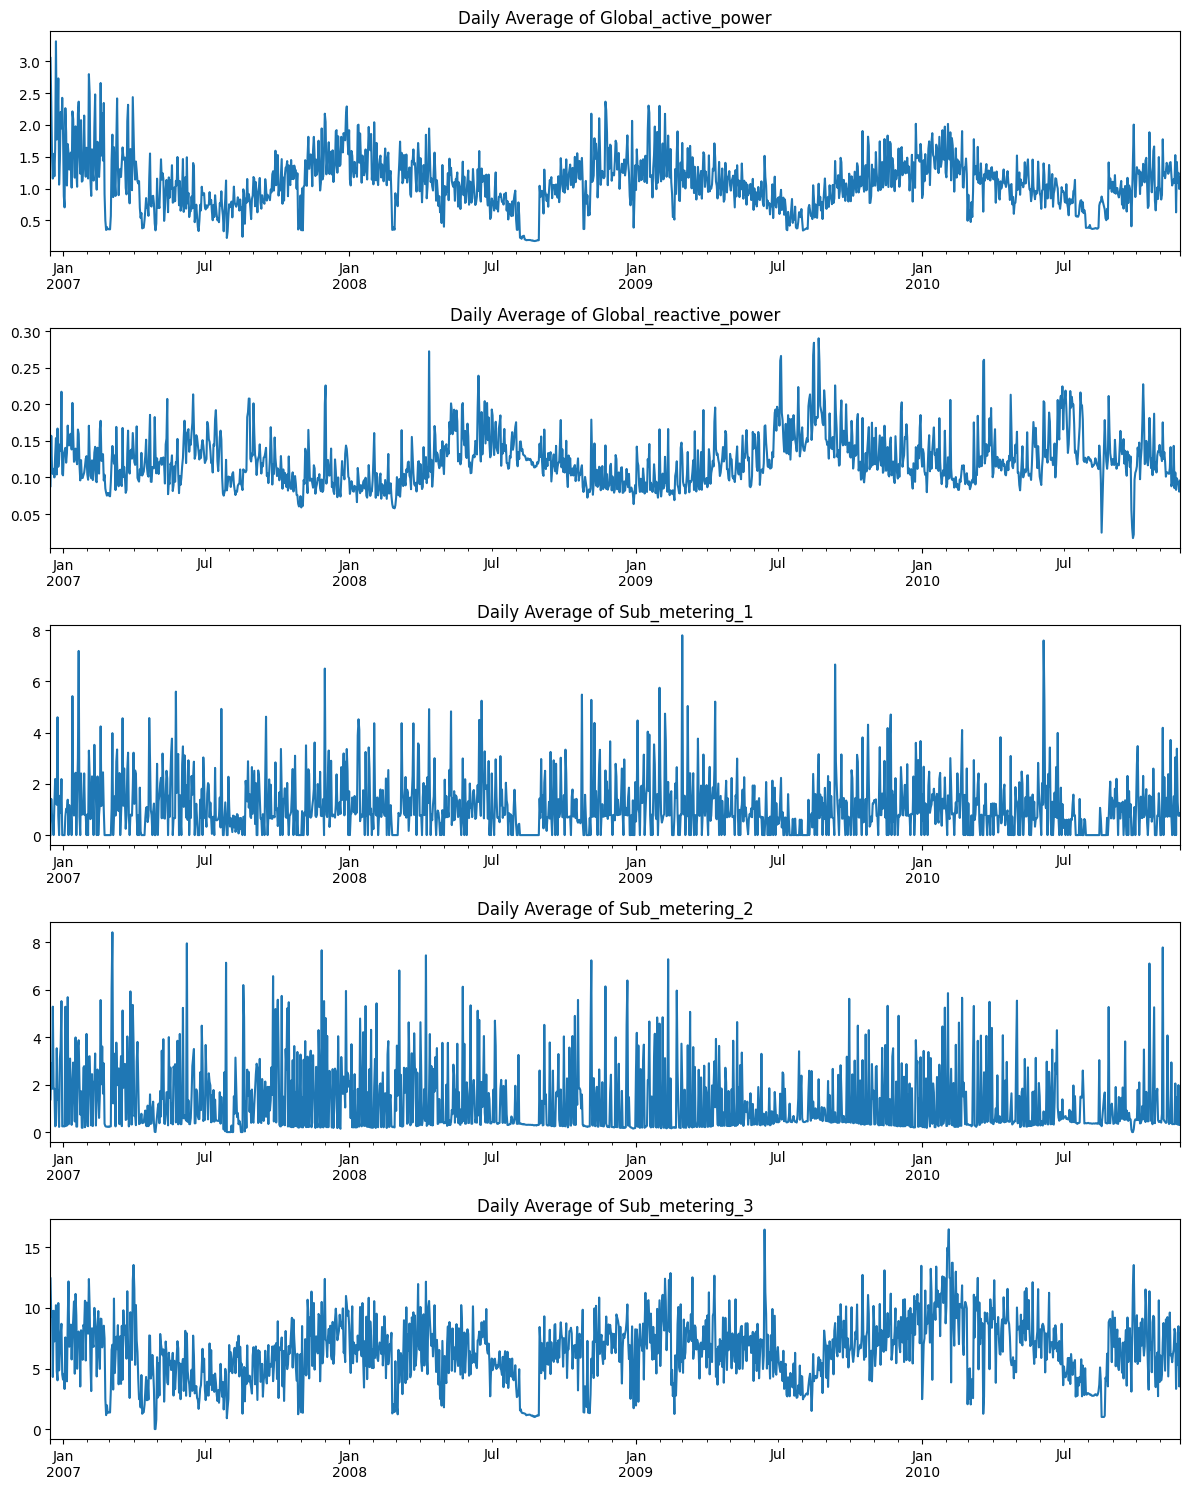

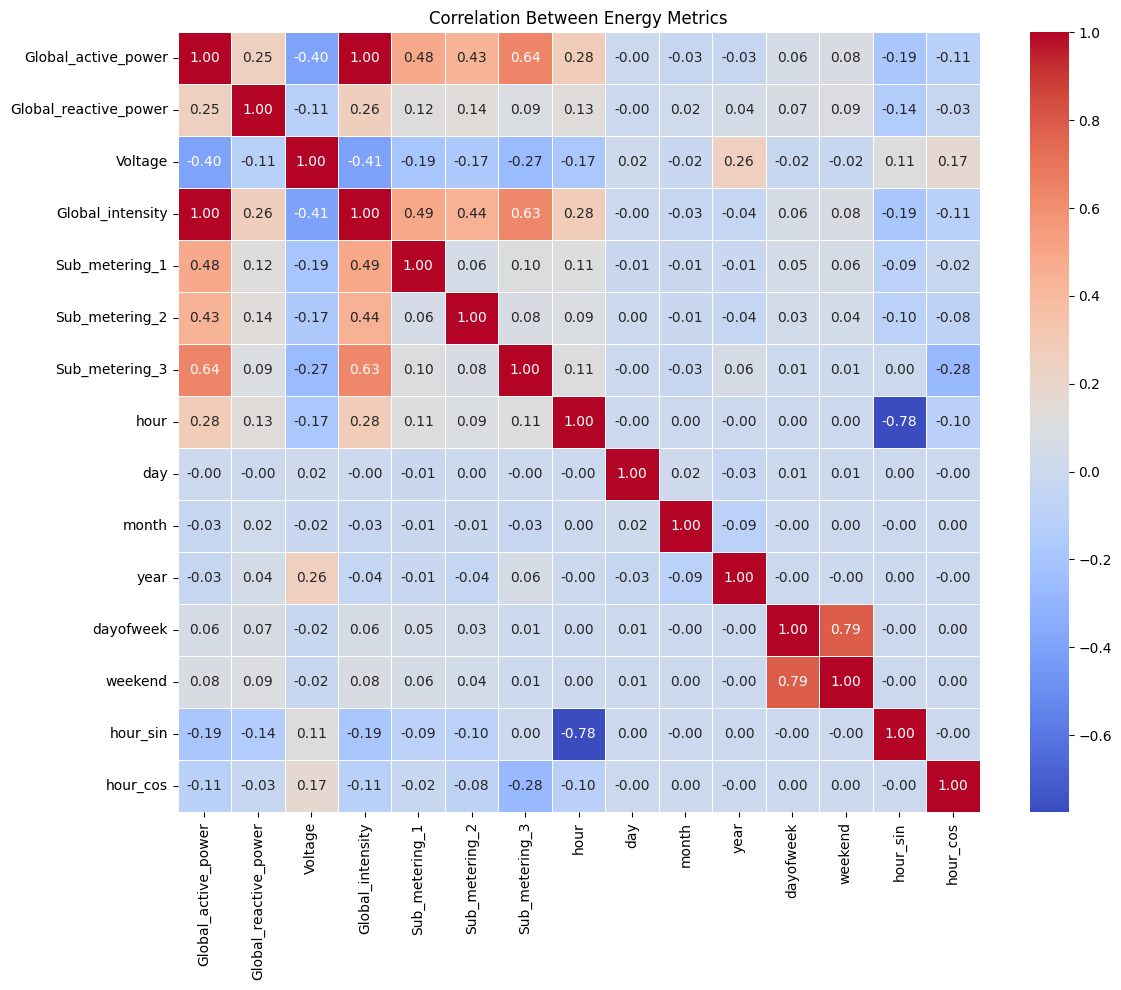

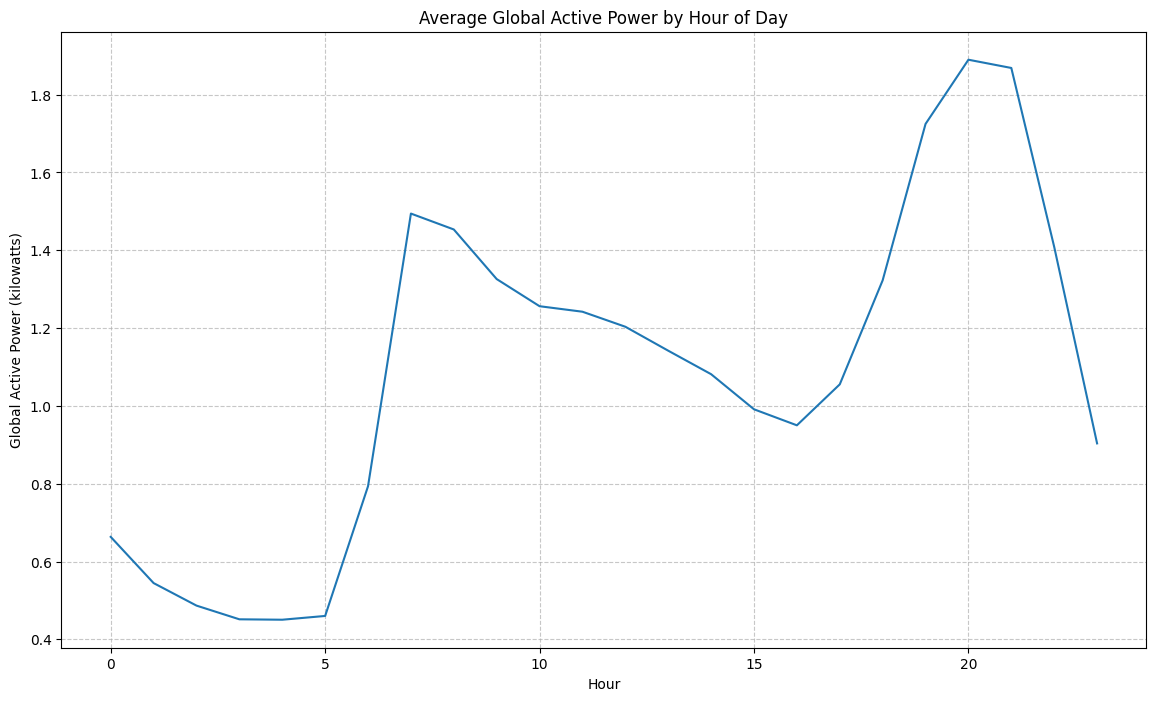

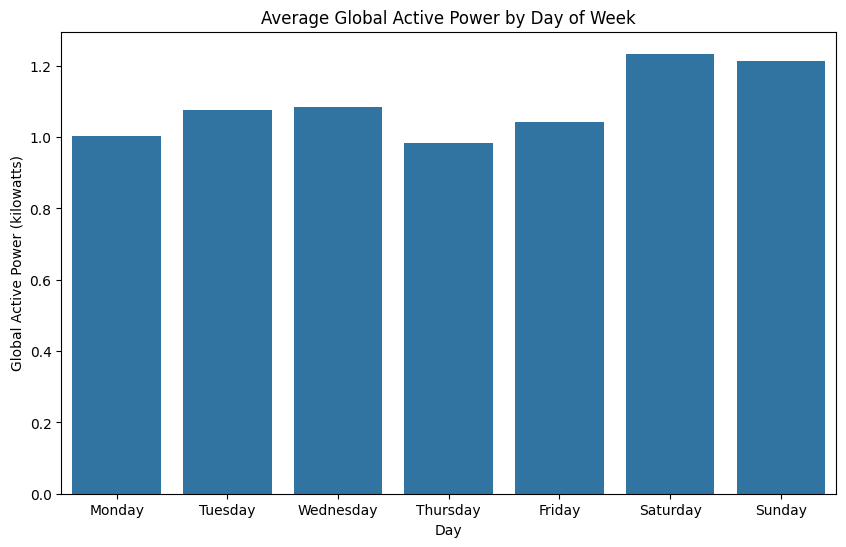

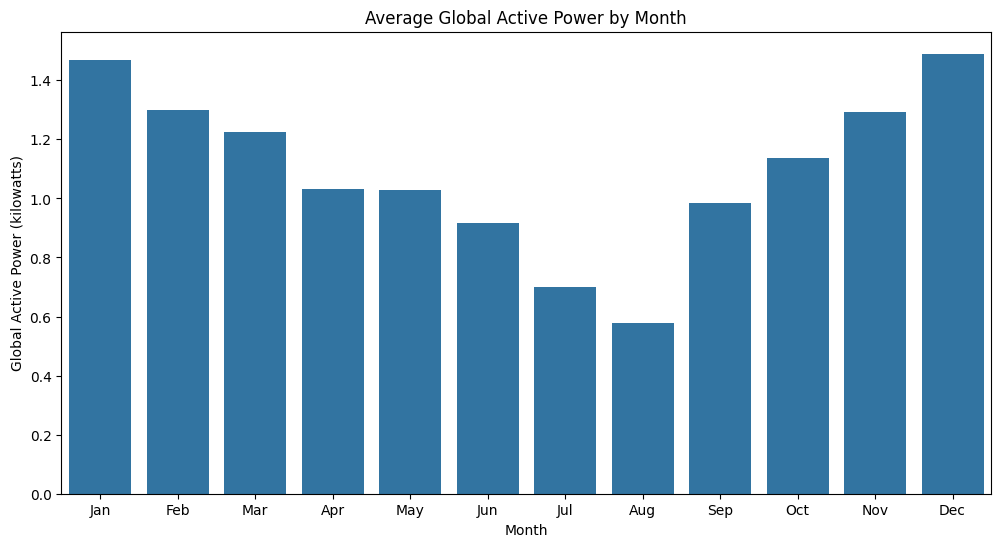

In [14]:
 def perform_eda(df):
    print("\nPerforming exploratory data analysis...")
    
    # Create a directory to save all plots
    import os
    if not os.path.exists('plots'):
        os.makedirs('plots')
    
    # Distribution of each variable
    plt.figure(figsize=(16, 12))
    for i, column in enumerate(df.select_dtypes(include=[np.number]).columns[:9]):  # First 9 numerical columns
        plt.subplot(3, 3, i+1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.savefig('plots/distributions.png')
    
    # Time series visualization for key metrics
    energy_columns = ['Global_active_power', 'Global_reactive_power', 'Sub_metering_1', 
                      'Sub_metering_2', 'Sub_metering_3']
    
    # Plot each energy metric
    plt.figure(figsize=(12, 15))
    for i, col in enumerate(energy_columns):
        plt.subplot(len(energy_columns), 1, i+1)
        # To avoid plotting too many points, resample to daily average
        df[col].resample('D').mean().plot()
        plt.title(f'Daily Average of {col}')
        plt.xlabel('')  # Only show date on bottom subplot
    plt.tight_layout()
    plt.savefig('plots/daily_energy_metrics.png')
    
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    correlation = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Between Energy Metrics')
    plt.tight_layout()
    plt.savefig('plots/correlation_heatmap.png')
    
    # Energy usage patterns by hour of day
    plt.figure(figsize=(14, 8))
    hourly_avg = df.groupby('hour')['Global_active_power'].mean()
    sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
    plt.title('Average Global Active Power by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('plots/hourly_power_usage.png')
    
    # Energy usage patterns by day of week
    plt.figure(figsize=(10, 6))
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_avg = df.groupby('dayofweek')['Global_active_power'].mean()
    sns.barplot(x=day_names, y=daily_avg.values)
    plt.title('Average Global Active Power by Day of Week')
    plt.xlabel('Day')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.savefig('plots/daily_power_usage.png')
    
    # Seasonal patterns (monthly averages)
    plt.figure(figsize=(12, 6))
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_avg = df.groupby('month')['Global_active_power'].mean()
    sns.barplot(x=month_names, y=monthly_avg.values)
    plt.title('Average Global Active Power by Month')
    plt.xlabel('Month')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.savefig('plots/monthly_power_usage.png')
    
    return

perform_eda(df_clean)

## Time Series Decomposition


Decomposing Global_active_power time series...


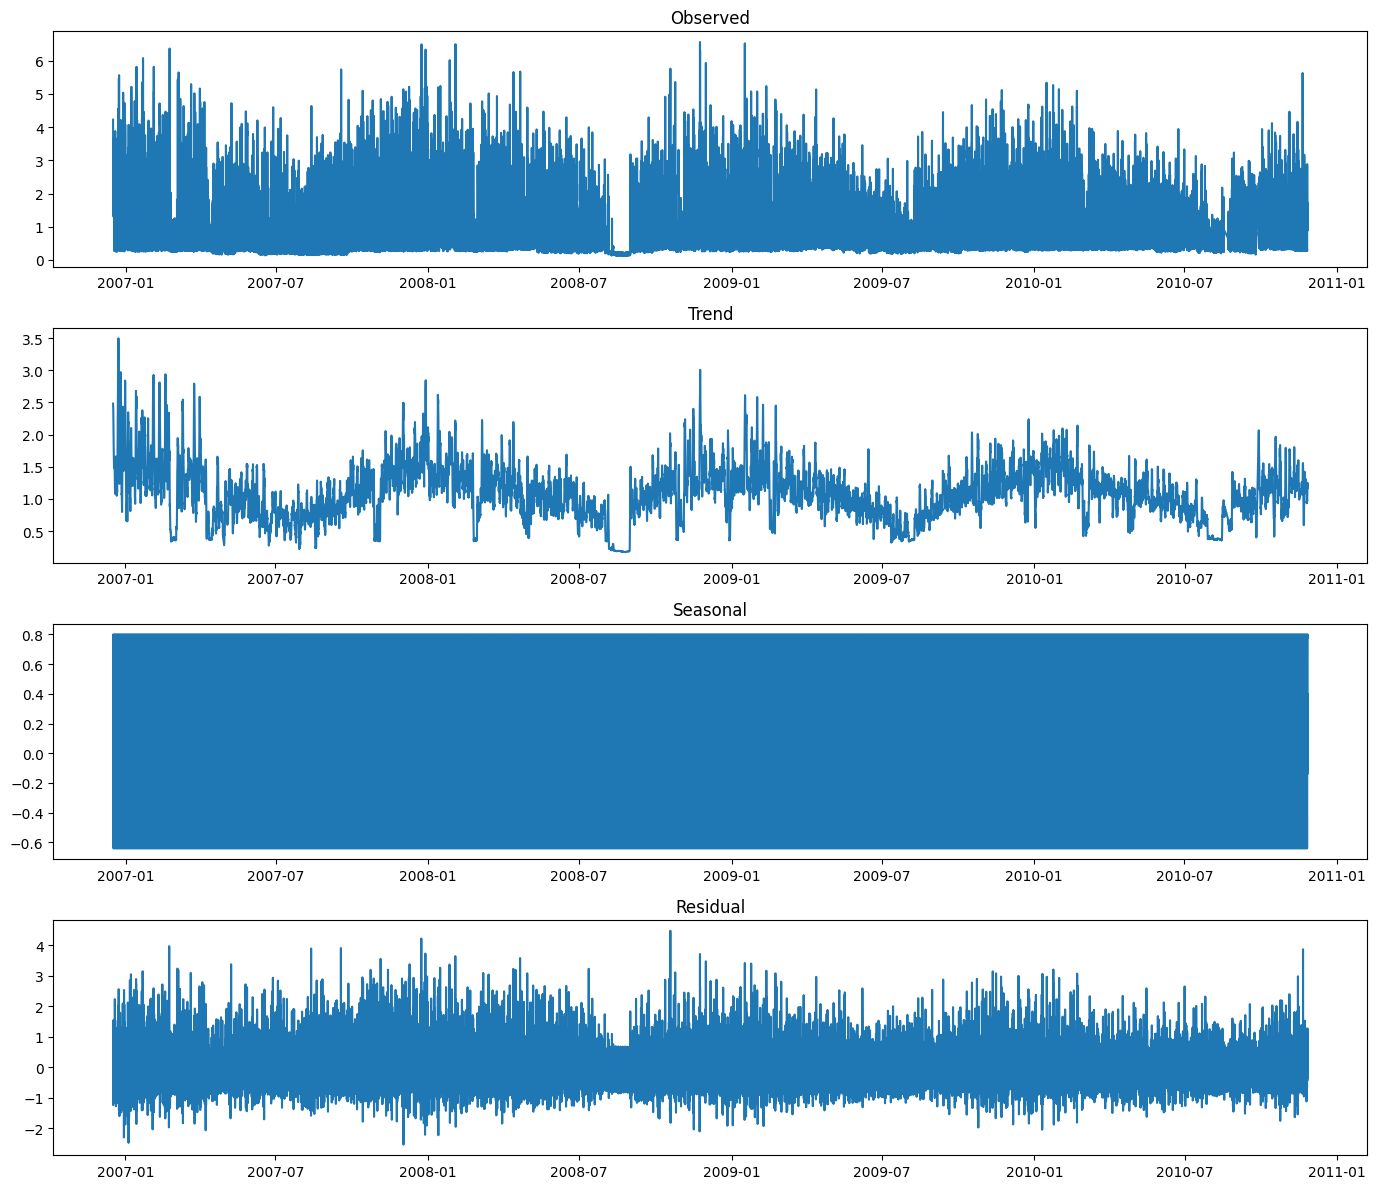

In [15]:
def decompose_time_series(df, column='Global_active_power', period=24):
    """Decompose time series into trend, seasonal, and residual components"""
    print(f"\nDecomposing {column} time series...")
    
    # For large datasets, we might need to resample
    # Resample to hourly data for decomposition
    df_resampled = df[column].resample('H').mean()
    
    # Fill any missing values created by resampling
    df_resampled = df_resampled.interpolate()
    
    # Decompose the time series
    decomposition = seasonal_decompose(df_resampled, model='additive', period=period)
    
    # Plot decomposition
    plt.figure(figsize=(14, 12))
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residual')
    plt.tight_layout()
    plt.savefig(f'plots/decomposition_{column}.png')
    
    return decomposition
decomposition = decompose_time_series(df_clean, column='Global_active_power', period=24)

## Is data Stationarity?

In [16]:
def test_stationarity(ts):
    print("\nPerforming Augmented Dickey-Fuller test...")
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")

# Test stationarity on the Global Active Power time series
test_stationarity(df_clean['Global_active_power'].resample('H').mean())


Performing Augmented Dickey-Fuller test...
ADF Statistic: -14.371344689221454
p-value: 9.482687472634345e-27
Critical Values:
   1%: -3.4305393559398922
   5%: -2.8616236906108443
   10%: -2.566814545887977
The time series is stationary.


##  ACF and PACF Analysis


Analyzing ACF and PACF for Global_active_power...


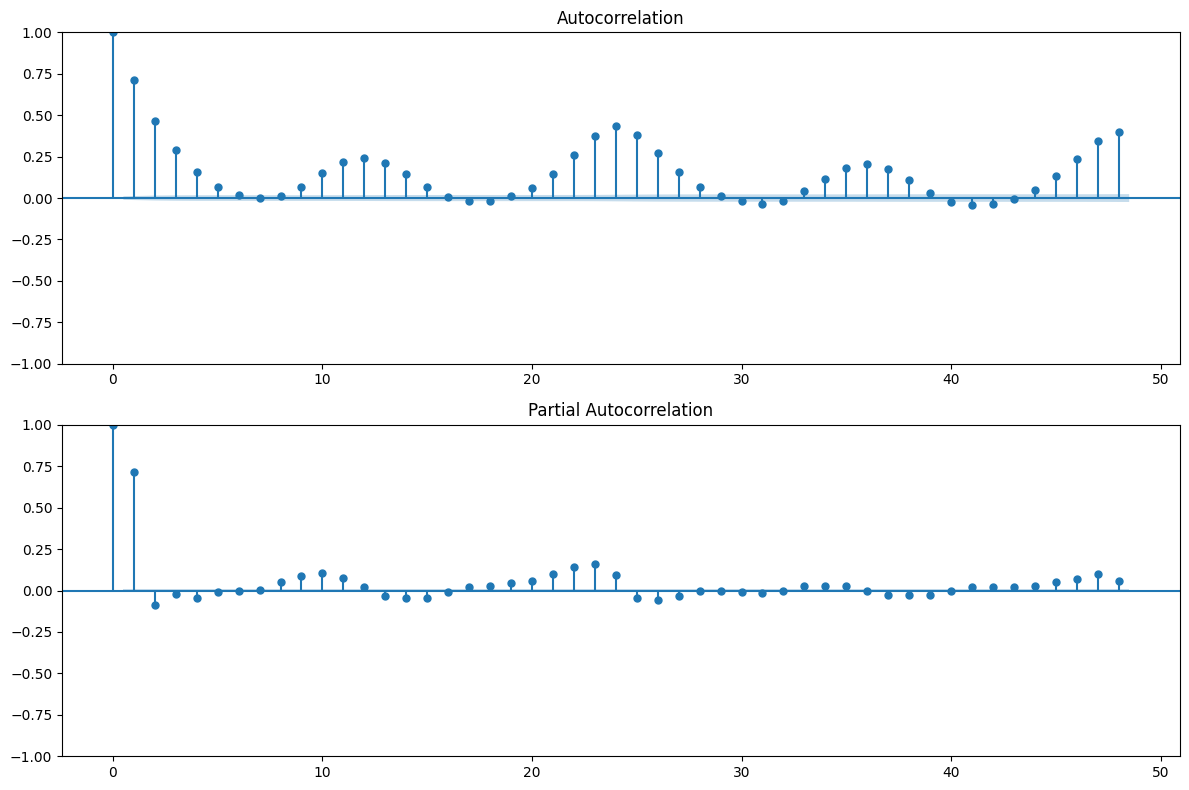

In [17]:
def analyze_acf_pacf(df, column, lags):
    """Plot ACF and PACF for parameter selection"""
    print(f"\nAnalyzing ACF and PACF for {column}...")
    
    # Resample to hourly data
    df_resampled = df[column].resample('H').mean().interpolate()
    
    # Create ACF and PACF plots
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(df_resampled.dropna(), lags=lags, ax=plt.gca())
    plt.subplot(212)
    plot_pacf(df_resampled.dropna(), lags=lags, ax=plt.gca())
    plt.tight_layout()
    plt.savefig(f'plots/acf_pacf_{column}.png')
    
    return
analyze_acf_pacf(df_clean, column='Global_active_power', lags=48)

## ARIMA Model

In [23]:
from pmdarima import auto_arima

def auto_arima_model(df, column='Global_active_power', test_size=0.2):
    """Automatically find the best ARIMA model"""
    print("\nFinding best ARIMA model using Auto ARIMA...")

    # Resample to hourly data
    df_resampled = df[column].resample('H').mean().interpolate()

    # Split into train/test sets
    train_size = int(len(df_resampled) * (1 - test_size))
    train, test = df_resampled[:train_size], df_resampled[train_size:]

    # Fit Auto ARIMA model
    model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
    print(model.summary())

    # Make predictions
    predictions = model.predict(n_periods=len(test))

    # Calculate error metrics
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, predictions)

    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

    return model, predictions, (mse, rmse, mae)

model, predictions, error_metrics = auto_arima_model(df_clean, column='Global_active_power', test_size=0.3)



Finding best ARIMA model using Auto ARIMA...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                24212
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -23313.778
Date:                Sat, 17 May 2025   AIC                          46639.557
Time:                        11:53:14   BIC                          46688.124
Sample:                    12-16-2006   HQIC                         46655.301
                         - 09-20-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.563e-06   7.44e-05     -0.034      0.973      -0.000       0.000
ar.L1          0.5227      0.012     43.481      0.000       0.499       0.546
ma.L1 